In [129]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf
from datetime import datetime

In [264]:
# SUPPORT FUNCTIONS DATA PROCESSING   
# def collect_datasets(files = ['a', 'b'],
#                      burn_in = 1000,
#                      sort_ = True):
#     dats = []
#     for file_ in files:
#         dats.append(pickle.load(open(file_ , 'rb')))

#     dat_tmp_0 = []
#     dat_tmp_1 = []
#     for dat in dats:
#         dat_tmp_0.append(dat[0])
#         dat_tmp_1.append(dat[2])

#     dat_total = [np.concatenate(dat_tmp_0, axis = 0), np.concatenate(dat_tmp_1, axis = 0)]


#     # Sort by first column in parameters
#     if sort_ == True:
#         ind = np.argsort(dat_total[0][:, 0])
#         dat_total[0] = dat_total[0][ind]
#         dat_total[1] = dat_total[1][ind]

#     # Calculate posterior means
#     means = np.mean(dat_total[1][:, burn_in:, :], axis = (1))
    
#     return (dat_total, means)

def get_r2_vec(estimates = [0, 0, 0],
               ground_truths = [0, 0, 0]):
    """Function reads in parameter estimates and group truths and returns regression function"""
    r2_vec = []
    for i in range(estimates.shape[1]):
        reg = LinearRegression().fit(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T)
        r2_vec.append(str(round(reg.score(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T), 2)))
    return r2_vec

def collect_datasets_diff_evo(in_files = [],
                              out_file = [],
                              burn_in = 5000,
                              n_post_samples_by_param = 10000,
                              sort_ = True,
                              save = True):
    """Function prepares raw mcmc data for plotting"""
    
    # Intialization
    in_files = sorted(in_files)
    tmp = pickle.load(open(in_files[0],'rb'))
    n_param_sets = len(in_files) * len(tmp[2])
    n_param_sets_file = len(tmp[2])
    n_chains = tmp[2][0][0].shape[0]
    n_samples = tmp[2][0][0].shape[1]
    n_params = tmp[2][0][0].shape[2]
    
    # Data containers 
    means = np.zeros((n_param_sets, n_params))
    maps = np.zeros((n_param_sets, n_params))
    orig_params = np.zeros((n_param_sets, n_params))
    r_hat_last = np.zeros((n_param_sets))
    posterior_subsamples = np.zeros((n_param_sets, n_post_samples_by_param, n_params))
    posterior_subsamples_ll = np.zeros((n_param_sets, n_post_samples_by_param))

    file_cnt = 0
    for file_ in in_files:
        # Load datafile in
        tmp_data = pickle.load(open(file_, 'rb'))
        for i in range(n_param_sets_file):
            
            # Extract samples and log likelihood sequences
            tmp_samples = np.reshape(tmp_data[2][i][0][:, burn_in:, :], (-1, n_params))
            tmp_log_l = np.reshape(tmp_data[2][i][1][:, burn_in:], (-1))        
            
            # Fill in return datastructures
            posterior_subsamples[(n_param_sets_file * file_cnt) + i, :, :] = tmp_samples[np.random.choice(tmp_samples.shape[0], size = n_post_samples_by_param), :]
            posterior_subsamples_ll[(n_param_sets_file * file_cnt) + i, :] = tmp_log_l[np.random.choice(tmp_log_l.shape[0], size = n_post_samples_by_param)]
            means[(n_param_sets_file * file_cnt) + i, :] = np.mean(tmp_samples, axis = 0)
            maps[(n_param_sets_file * file_cnt) + i, :] = tmp_samples[np.argmax(tmp_log_l), :]
            orig_params[(n_param_sets_file * file_cnt) + i, :] = tmp_data[0][i, :]
            r_hat_last[(n_param_sets_file * file_cnt) + i] = tmp_data[2][i][2][-1]
            
        print(file_cnt)
        file_cnt += 1
    
    out_dict = {'means': means, 'maps': maps, 'gt': orig_params, 'r_hats': r_hat_last, 'posterior_samples': posterior_subsamples, 'posterior_ll': posterior_subsamples_ll}
    if save == True:
        print('writing to file to ' + out_file)
        pickle.dump(out_dict, open(out_file, 'wb'), protocol = 2)
    
    return out_dict

In [269]:
# SUPPORT FUNCTIONS GRAPHS
def parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            title = 'Parameter Recovery: ABC-NN',
                            ground_truths = [0, 0, 0],
                            estimates = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3,
                            color_param = 0,
                            save = True): # color_param 'none' 
    
    grayscale_map = plt.get_cmap('gray')
    normalized_params = np.zeros(estimates.shape)
    for i in range(estimates.shape[1]):
        normalized_params[:, i] = (estimates[:, i] - np.min(estimates[:, i])) \
        / (np.max(estimates[:, i]) - np.min(estimates[:, i]))

    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    
    fig.suptitle(title, fontsize = 40)
    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        if color_param != 'none':
            sns.regplot(ground_truths[:, i], estimates[:, i],
                        color = 'black',
                        marker =  '+',
                        ax = ax[row_tmp, col_tmp],
                        scatter_kws = {'s': 120, 'alpha': 0.5, 'color': grayscale_map(normalized_params[:,  color_param])})
        else:
            sns.regplot(ground_truths[:, i], estimates[:, i], 
                        color = 'black', 
                        marker =  '+',
                        ax = ax[row_tmp, col_tmp],
                        scatter_kws = {'s': 120, 'alpha': 0.5})
            
        ax[row_tmp, col_tmp].text(0.7, 0.1, '$R^2$: ' + r2_vec[i], 
                                  transform = ax[row_tmp, col_tmp].transAxes, 
                                  fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    
    
    if save == True:
        
        figure_name = 'parameter_recovery_plot_'
        date_time = now.strftime("%m_%d_%Y")
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model + date_time, dpi = 150, )
   
    return plt.show()


def posterior_predictive_plot(ax_titles = [], 
                              title = 'POSTERIOR PREDICTIVES',
                              x_labels = [],
                              posterior_samples = [],
                              ground_truths = [],
                              cols = 3,
                              model = 'angle',
                              figure_name = 'Posterior Predictives',
                              n_post_params = 100,
                              samples_by_param = 10,
                              save = False,
                              show = True):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)
    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        post_tmp = np.zeros((n_post_params * samples_by_param, 2))
        idx = np.random.choice(posterior_samples.shape[1], size = n_post_params, replace = False)

        # Run Model simulations for posterior samples
        for j in range(n_post_params):
            if model == 'ddm':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        s = 1,
                                        delta_t = 0.001,
                                        max_t = 20, 
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.constant,
                                        boundary_multiplicative = True,
                                        boundary_params = {})
                
            if model == 'full_ddm':
                out = cds.full_ddm(v = posterior_samples[i, idx[j], 0],
                                   a = posterior_samples[i, idx[j], 1],
                                   w = posterior_samples[i, idx[j], 2],
                                   dw = posterior_samples[i, idx[j], 3],
                                   sdv = posterior_samples[i, idx[j], 4],
                                   dndt = posterior_samples[i, idx[j], 5],
                                   ndt = posterior_samples[i, idx[j], 6],
                                   s = 1,
                                   delta_t = 0.001,
                                   max_t = 20,
                                   n_samples = samples_by_param,
                                   print_info = False,
                                   boundary_fun = bf.constant,
                                   boundary_multiplicative = True,
                                   boundary_params = {})

            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_samples[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_samples[i, idx[j], 4],
                                                           'beta': posterior_samples[i, idx[j], 5]})
            if model == 'levy':
                out = cds.levy_flexbound(v = posterior_samples[i, idx[j], 0],
                                         a = posterior_samples[i, idx[j], 1],
                                         w = posterior_samples[i, idx[j], 2],
                                         alpha_diff = posterior_samples[i, idx[j], 3],
                                         ndt = posterior_samples[i, idx[j], 4],
                                         s = 1,
                                         delta_t = 0.001,
                                         max_t = 20,
                                         n_samples = samples_by_param,
                                         print_info = False,
                                         boundary_fun = bf.constant,
                                         boundary_multiplicative = True, 
                                         boundary_params = {})
            
            if model == 'ornstein':
                out = cds.ornstein_uhlenbeck(v = posterior_samples[i, idx[j], 0],
                                             a = posterior_samples[i, idx[j], 1],
                                             w = posterior_samples[i, idx[j], 2],
                                             g = posterior_samples[i, idx[j], 3],
                                             ndt = posterior_samples[i, idx[j], 4],
                                             s = 1,
                                             delta_t = 0.001, 
                                             max_t = 20,
                                             n_samples = samples_by_param,
                                             print_info = False,
                                             boundary_fun = bf.constant,
                                             boundary_multiplicative = True,
                                             boundary_params ={})
            
            post_tmp[(samples_by_param * j):(samples_by_param * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        # Run Model simulations for true parameters
        if model == 'ddm':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    s = 1,
                                    delta_t = 0.001,
                                    max_t = 20, 
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.constant,
                                    boundary_multiplicative = True,
                                    boundary_params = {})

        if model == 'full_ddm':
            out = cds.full_ddm(v = ground_truths[i, 0],
                               a = ground_truths[i, 1],
                               w = ground_truths[i, 2],
                               dw = ground_truths[i, 3],
                               sdv = ground_truths[i, 4],
                               dndt = ground_truths[i, 5],
                               ndt = ground_truths[i, 6],
                               s = 1,
                               delta_t = 0.001,
                               max_t = 20,
                               n_samples = 10000,
                               print_info = False,
                               boundary_fun = bf.constant,
                               boundary_multiplicative = True,
                               boundary_params = {})

        if model == 'angle':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.001, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': ground_truths[i, 4]})

        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.001, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': ground_truths[i, 4],
                                                       'beta': ground_truths[i, 5]})
        if model == 'levy':
            out = cds.levy_flexbound(v = ground_truths[i, 0],
                                     a = ground_truths[i, 1],
                                     w = ground_truths[i, 2],
                                     alpha_diff = ground_truths[i, 3],
                                     ndt = ground_truths[i, 4],
                                     s = 1,
                                     delta_t = 0.001,
                                     max_t = 20,
                                     n_samples = 10000,
                                     print_info = False,
                                     boundary_fun = bf.constant,
                                     boundary_multiplicative = True, 
                                     boundary_params = {})

        if model == 'ornstein':
            out = cds.ornstein_uhlenbeck(v = ground_truths[i, 0],
                                         a = ground_truths[i, 1],
                                         w = ground_truths[i, 2],
                                         g = ground_truths[i, 3],
                                         ndt = ground_truths[i, 4],
                                         s = 1,
                                         delta_t = 0.001, 
                                         max_t = 20,
                                         n_samples = 10000,
                                         print_info = False,
                                         boundary_fun = bf.constant,
                                         boundary_multiplicative = True,
                                         boundary_params ={})
        
        gt_tmp = np.concatenate([out[0], out[1]], axis = 1)
        print('passed through')
            
        sns.distplot(post_tmp[:, 0] * post_tmp[:, 1], 
                     bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 0.2, 'color': 'blue', 'density': 1},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(gt_tmp[:, 0] * gt_tmp[:, 1], 
                     hist_kws = {'alpha': 0.2, 'color': 'green', 'density': 1}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        
        if row_tmp == 0:
            ax[row_tmp, col_tmp].legend(labels = [model, 'posterior'], 
                                        fontsize = 20)
        
        if row_tmp == rows:
            ax[row_tmp, col_tmp].set_xlabel('rt', 
                                            fontsize = 24);
        
        if col_tmp == 0:
            ax[row_tmp, col_tmp].set_ylabel('density', 
                                            fontsize = 24);
        
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    if save == True:
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model, dpi = 150)
    
    if show:
        return plt.show()

  
# Plot bound
# Mean posterior predictives
def boundary_posterior_plot(ax_titles = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'], 
                            title = 'Model uncertainty plot: ',
                            posterior_samples = [],
                            ground_truths = [],
                            cols = 3,
                            model = 'weibull_cdf',
                            figure_name = 'bg_posterior_bounds',
                            n_post_params = 500,
                            samples_by_param = 10,
                            max_t = 2,
                            show = True,
                            save = False):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sub_idx = np.random.choice(posterior_samples.shape[1], size = n_post_params)
    posterior_samples = posterior_samples[:, sub_idx, :]
    
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    
    my_suptitle = fig.suptitle(title + model, fontsize = 40)
    sns.despine(right = True)
    
    t_s = np.arange(0, max_t, 0.01)
    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        idx = np.random.choice(posterior_samples.shape[1], size = n_post_params, replace = False)

        ax[row_tmp, col_tmp].set_xlim(0, max_t)
        ax[row_tmp, col_tmp].set_ylim(-2, 2)
        # Run simulations and add histograms
        # True params
        if model == 'angle':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': ground_truths[i, 4]})
            
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': ground_truths[i, 4],
                                                       'beta': ground_truths[i, 5]})
        tmp_true = np.concatenate([out[0], out[1]], axis = 1)
        choice_p_up_true = np.sum(tmp_true[:, 1] == 1) / tmp_true.shape[0]
        
        # Run Model simulations for posterior samples
        tmp_post = np.zeros((n_post_params*samples_by_param, 2))
        for j in range(n_post_params):
            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_samples[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_samples[i, idx[j], 4],
                                                           'beta': posterior_samples[i, idx[j], 5]})
            
            tmp_post[(10 * j):(10 * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        choice_p_up_post = np.sum(tmp_post[:, 1] == 1) / tmp_post.shape[0]
        
        #ax.set_ylim(-4, 2)
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(-2, 2)
        ax_tmp.set_yticks([])
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_post * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_true * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
             
        #ax.invert_xaxis()
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(2, -2)
        ax_tmp.set_yticks([])
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                        bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_post) * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_true) * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
      
        # Plot posterior samples 
        for j in range(n_post_params):
            if model == 'weibull_cdf':
                b = posterior_samples[i, idx[i], 1] * bf.weibull_cdf(t = t_s, 
                                                                        alpha = posterior_samples[i, idx[j], 4],
                                                                        beta = posterior_samples[i, idx[j], 5])
            if model == 'angle':
                b = np.maximum(posterior_samples[i, idx[i], 1] + bf.angle(t = t_s, 
                                                                             theta = posterior_samples[i, idx[j], 4]), 0)
            
            start_point_tmp = - posterior_samples[i, idx[j], 1] + \
                              (2 * posterior_samples[i, idx[j], 1] * posterior_samples[i, idx[j], 2])
            slope_tmp = posterior_samples[i, idx[j], 0]
            
            ax[row_tmp, col_tmp].plot(t_s + posterior_samples[i, idx[j], 3], b, 'black',
                                      t_s + posterior_samples[i, idx[j], 3], -b, 'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
            for m in range(len(t_s)):
                if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                    maxid = m
                    break
                maxid = m
            
            ax[row_tmp, col_tmp].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                      start_point_tmp + slope_tmp * t_s[:maxid], 
                                      'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
        # Plot true ground_truths  
        if model == 'weibull_cdf':
            b = ground_truths[i, 1] * bf.weibull_cdf(t = t_s, 
                                            alpha = ground_truths[i, 4],
                                            beta = ground_truths[i, 5])
        if model == 'angle':
            b = np.maximum(ground_truths[i, 1] + bf.angle(t = t_s, theta = ground_truths[i, 4]), 0)

        start_point_tmp = - ground_truths[i, 1] + \
                          (2 * ground_truths[i, 1] * ground_truths[i, 2])
        slope_tmp = ground_truths[i, 0]

        ax[row_tmp, col_tmp].plot(t_s + ground_truths[i, 3], b, 'red', 
                                  t_s + ground_truths[i, 3], -b, 'red', 
                                  alpha = 1,
                                  linewidth = 3,
                                  zorder = 1000)
        
        for m in range(len(t_s)):
            if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                maxid = m
                break
            maxid = m
        
        print('maxid', maxid)
        ax[row_tmp, col_tmp].plot(t_s[:maxid] + ground_truths[i, 3], 
                                  start_point_tmp + slope_tmp * t_s[:maxid], 
                                  'red', 
                                  alpha = 1, 
                                  linewidth = 3, 
                                  zorder = 1000)
        
        ax[row_tmp, col_tmp].set_zorder(ax_tmp.get_zorder() + 1)
        ax[row_tmp, col_tmp].patch.set_visible(False)
        print('passed through')
        
        #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        if row_tmp == rows:
            ax[row_tmp, col_tmp].set_xlabel('rt', 
                                            fontsize = 20);
        ax[row_tmp, col_tmp].set_ylabel('', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 20)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    if save:
        plt.savefig(os.getcwd() + '/figures/' + figure_name + model,
                    dpi = 150, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    if show:
        return plt.show()


# def trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                 param_lims = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)],
#                 title = 'Trace Plots',
#                 posterior_samples = [0, 0, 0],
#                 ground_truths = [0, 0, 0],
#                 trace_id = 1,
#                 cols = 3):
    
#     T = posterior_samples.shape[1]
#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, 
#                            cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = False)

#     sns.despine(right = True)

#     for i in range(posterior_samples.shape[2]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         sns.lineplot(data = posterior_samples[trace_id, :, i], 
#                      color = 'black', 
#                      ax = ax[row_tmp, col_tmp])
#         ax[row_tmp, col_tmp].axhline(y = ground_truths[trace_id, i], color = 'red')
#         ax[row_tmp, col_tmp].set_ylim(param_lims[i])
#         ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y", 
#                                          labelsize = 24)

#     for i in range(posterior_samples.shape[2], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     #plt.setp(ax, yticks = [])
#     plt.tight_layout()
    
    
# def correlation_hist_plot(data = [0, 0, 0],
#                           ax_titles = ['v', 'a', 'w', 'ndt', 'angle']): 
    
#     # Plot histograms of correlations between parameters
#     # Get array of correlation matrices for all plots
#     corr_mat_array = np.zeros((data[1].shape[0], data[0].shape[1], data[0].shape[1]))   
#     for i in range(data[1].shape[0]):
#         corr_mat_array[i, :, :] = pd.DataFrame(data[1][i, : ,:], columns = ax_titles).corr()

#     grid_size = corr_mat_array.shape[2] - 1

#     fig, ax = plt.subplots(grid_size, grid_size, 
#                            figsize = (20, 20), 
#                            sharex = True, 
#                            sharey = True)

#     fig.suptitle('Posterior Correlations Between Parameters', fontsize = 40)
#     grayscale_map = plt.get_cmap('YlGn')

#     normalized_params = np.zeros(data[0].shape)
#     for i in range(corr_mat_array.shape[1]):
#         normalized_params[:, i] = (data[0][:, i] - np.min(data[0][:, i])) \
#         / (np.max(data[0][:, i]) - np.min(data[0][:, i]))


#     for i in range(grid_size):
#         for j in range(grid_size):
#             if j > i:
#                 ax[i, j].axis('off')
#             else:
#                 sns.distplot(corr_mat_array[:, - (i + 2), - (j + 1)], 
#                              bins = 20,
#                              color = 'black',
#                              norm_hist = True,
#                              kde = True,
#                              rug = True,
#                              rug_kws = {"c": grayscale_map(normalized_params[:,  - (j + 1)]), 
#                                         'alpha': 0.3},
#                              ax = ax[i, j])

#                 if j == 0:
#                     ax[i, j].set_ylabel(ax_titles[- (i + 2)], 
#                                         fontsize = 24);
#                     ax[i, j].tick_params(axis = "y", 
#                                          labelsize = 20)
#                 if i == (grid_size - 1):
#                     ax[i, j].set_xlabel(ax_titles[- (j + 1)], 
#                                         fontsize = 24);
#                     ax[i, j].tick_params(axis = "x", 
#                                          labelsize = 20)

#     ax[i, j].set_yticks(ax[i, j].get_yticks()[::2])                
#     #plt.tight_layout()
#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
# def get_posterior_variances(data = [0, 0, 0],
#                             ax_titles = ['v', 'a', 'w', 'ndt']):
    
#     # MLP
#     var_data = np.array(np.zeros((data[0].shape[0], data[0].shape[1])))
    
#     for i in range(data[0].shape[0]):
#         var_data[i, :] = np.diag(pd.DataFrame(data[1][i, : ,:], columns = ax_titles).cov())
#     return var_data

    
# def posterior_variance_comparison_hist(var_data_1 = [],
#                                        var_data_2 = [],
#                                        var_data_1_title = '..',
#                                        var_data_2_title = '..',
#                                        ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                                        cols = 3):  

#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = True)
#     fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
#                  fontsize = 40)
#     sns.despine(right = True)

#     x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

#     for i in range(var_data_1.shape[1]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)

#         sns.distplot(np.log((var_data_1[:, i])) -  np.log((var_data_2[:, i])), 
#                      bins = 20,
#                      color = 'black',
#                      norm_hist = True,
#                      kde = False,
#                      rug = False,
#                      #rug_kws = {"c": grayscale_map(dat_total[0][:, j]), 'alpha': 0.3},
#                      ax = ax[row_tmp, col_tmp])

#         ax[row_tmp, col_tmp].set_xlabel(x_title, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y",
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)

#     for i in range(var_data_1.shape[1], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
#     #plt.show()
    

# def posterior_variance_comparison_reg(var_data_1 = [],
#                                       var_data_2 = [],
#                                       params = [], # need params here because we used normalize params to color graphs
#                                       var_data_1_title = '..',
#                                       var_data_2_title = '..',
#                                       ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                                       cols = 3):  
#     # 
#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = False)

#     fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
#                  fontsize = 40)
#     sns.despine(right = True)

#     x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

#     # Get normalized parameters for coloring purposes
#     normalized_params = np.zeros(params.shape)
#     for i in range(params.shape[1]):
#         normalized_params[:, i] = (params[:, i] - np.min(params[:, i])) \
#         / (np.max(params[:, i]) - np.min(params[:, i]))

#     for i in range(params.shape[1]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         sns.regplot(np.log(var_data_1[:, i]), np.log(var_data_2[:, i]),
#                     marker =  '+',
#                     ax = ax[row_tmp, col_tmp],
#                     scatter_kws = {'s': 120, 
#                                    'alpha': 0.5,
#                                    'color': grayscale_map(normalized_params[:, i])},
#                     line_kws = {'color': 'black'})

#         xlabel_tmp = '$ \ln(\sigma^2_{' +  var_data_1_title  + '})$: ' + ax_titles[i]
#         ylabel_tmp = '$ \ln(\sigma^2_{' +  var_data_2_title  + '})$: ' + ax_titles[i]
        
#         ax[row_tmp, col_tmp].set_xlabel(xlabel_tmp, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].set_ylabel(ylabel_tmp, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y", 
#                                          labelsize = 24)

#     for i in range(params.shape[1], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     #plt.setp(ax, yticks = [])
#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
#     #plt.show()

In [265]:
# REMAINING META

# DDM Angle
ax_titles_angle = ['v', 'a', 'w', 'ndt', 'angle']
param_lims_angle = [(-1.9, 1.9), (0.4, 1.9), (0.25,0.75), (0.1, 1.9), (0, 1.2)]

# DDM
ax_titles_ddm = ['v', 'a', 'w', 'ndt']
param_lims_ddm = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (0.1, 1.9)]

# WEIBULL 
ax_titles_weibull = ['v', 'a', 'w', 'ndt', 'alpha', 'beta']
param_lims_weibull = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (0.1, 1.9)]

# ORNSTEIN
ax_titles_ornstein = ['v', 'a', 'w', 'g', 'ndt']
param_lims_ornstein = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (-0.9, 0.9), (0.1, 1.9)]

# FULL_DDM
ax_titles_full_ddm = ["v", "a", "w", "ndt", "dw", "sdv", "dndt"]
param_lims_full_ddm = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.65), (0.3, 2.2), (0.05, 0.35), (0.05, 0.45), (0.05, 0.2)]

# LEVY
ax_titles_levy = ["v", 'a', 'w', 'alpha_diff', 'ndt']
param_lims_full_ddm = [(-1.9, 1.9), (0.4, 2), (0.3, 0.7), (1.1, 1.9), (0.1, 1.9)]

In [6]:
# Initial file read in 
models = ['ddm', 'full_ddm', 'levy', 'weibull_cdf', 'ornstein', 'angle']
for model in models:
    method_comparison_folder = '/media/data_cifs/afengler/data/kde/' + model + '/method_comparison/'
    file_signature = 'post_samp_data_param_recov_unif_reps_1_n_1024_1_'
    summary_file = method_comparison_folder + 'summary_' + file_signature[:-1] + '.pickle'
    file_signature_len = len(file_signature)
    files = os.listdir(method_comparison_folder)
    files_ = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]
    
    # Create summary file
    mcmc_dict = collect_datasets_diff_evo(in_files = files_,
                                          out_file = summary_file,
                                          burn_in = 5000,
                                          sort_ = True,
                                          save = True)

In [6]:
# Create summary file
mcmc_dict = collect_datasets_diff_evo(in_files = files_[:10],
                                      out_file = summary_file,
                                      burn_in = 5000,
                                      sort_ = True,
                                      save = True)

0
1
2
3
4
5
6
7
8
9
writing to file to /media/data_cifs/afengler/data/kde/ddm/method_comparison/summary_post_samp_data_param_recov_unif_reps_1_n_1024_1.pickle


In [276]:
# Folder data
model = 'angle'
#method_comparison_folder = '/media/data_cifs/afengler/data/kde/' + model + '/method_comparison/'
method_comparison_folder = '/Users/afengler/OneDrive/project_nn_likelihoods/data/kde/' + model + '/method_comparison/'

file_signature = 'post_samp_data_param_recov_unif_reps_1_n_1024_1_'
summary_file = method_comparison_folder + 'summary_' + file_signature[:-1] + '.pickle'

# Read in summary file
mcmc_dict = pickle.load(open(summary_file, 'rb'))

if model == 'dd':
    drop_id = np.nonzero(mcmc_dict['means'] < - 100)[0][0]
    mcmc_dict['means'] = np.delete(mcmc_dict['means'], drop_id, 0)
    mcmc_dict['maps'] = np.delete(mcmc_dict['maps'], drop_id, 0)
    mcmc_dict['posterior_samples'] = np.delete(mcmc_dict['posterior_samples'], drop_id, 0)
    mcmc_dict['gt'] = np.delete(mcmc_dict['gt'], drop_id, 0)
    mcmc_dict['r_hats'] = np.delete(mcmc_dict['r_hats'], drop_id, 0)

In [257]:
mcmc_dict[]

(array([], dtype=int64), array([], dtype=int64))

In [169]:
mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :]

array([[ 0.47641476,  1.08609931,  0.35500493,  0.79006398],
       [-1.29530436,  0.43358289,  0.22150324,  1.33910536],
       [ 1.35536787,  1.63791605,  0.48118641,  0.13664969],
       ...,
       [ 1.03946736,  0.76418811,  0.75350858,  0.80403824],
       [-1.30603189,  1.96521873,  0.2200735 ,  0.39830263],
       [ 0.94501674,  1.59674702,  0.44346448,  1.966829  ]])

In [195]:
mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :][28,:]

array([ 2.95065705e+299,             -inf, -1.29139828e+301,
        4.65788939e+302])

In [237]:
np.mean(mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, :, :], axis = 0)

array([ 6.11057138e+297, -5.21633641e+303,  8.83237200e+253,
        2.54570157e+297])

In [243]:
np.mean(mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, :, :])

-1.3040819394775089e+303

In [ ]:
mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :][28, :] = np.mean(mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, :, :], axis = 0)

In [247]:
#mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, 9924, :] 
mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, 9925, :]
#mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :][28, :] = np.mean(mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][28, :, :], axis = 0)

array([0.26095194, 1.8259675 , 0.78      , 1.42349376])

In [241]:
mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :][28, :]

array([ 2.95065705e+299,             -inf, -1.29139828e+301,
        4.65788939e+302])

In [194]:
np.nonzero(np.isinf(mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :]))

(array([28]), array([1]))

In [277]:
# Get regression coefficients on mcmc_dict 
r2_vec_means = get_r2_vec(estimates = mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :], 
                          ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :])

r2_vec_maps = get_r2_vec(estimates = mcmc_dict['maps'][mcmc_dict['r_hats'] < 1.01, :], 
                          ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :])



#mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :]

In [9]:
r2_vec_means

['0.96', '0.89', '0.94', '0.99', '0.9']

In [38]:
mcmc_dict['gt'][mcmc_dict['r_hats'] > 1.01, :].shape

(755, 6)

In [39]:
mcmc_dict['r_hats']

array([1.00102657, 1.06928529, 1.001468  , 1.10693613, 1.00029456,
       1.2129264 , 1.26795357, 1.04157296, 1.05407549, 1.0662095 ,
       1.04500957, 1.08027066, 1.06176215, 1.09264504, 1.04425313,
       1.00010899, 1.15414517, 1.03765744, 1.37583514, 1.0632699 ,
       1.05135445, 1.03087547, 1.21056099, 1.08859984, 1.0516552 ,
       1.05587185, 1.00200853, 1.25094612, 1.1423924 , 1.06908119,
       1.02803233, 1.007477  , 1.246738  , 1.11336956, 1.00351732,
       1.06241034, 1.19868604, 1.05285025, 1.56399933, 1.02480336,
       1.00014891, 3.34974267, 4.03587   , 1.00289427, 1.28104434,
       1.05521497, 1.01917334, 1.00009886, 1.00228571, 1.06699528,
       1.00060448, 1.02586081, 1.11732926, 1.0323262 , 1.04151263,
       1.00005691, 1.14103458, 1.0333701 , 1.0171133 , 1.00103789,
       1.1220074 , 1.02491822, 1.08207923, 1.29139297, 1.00105452,
       1.44533032, 2.3453305 , 1.00012962, 1.0468599 , 1.20049118,
       1.0297905 , 1.00018312, 1.09044581, 1.10542009, 1.01770

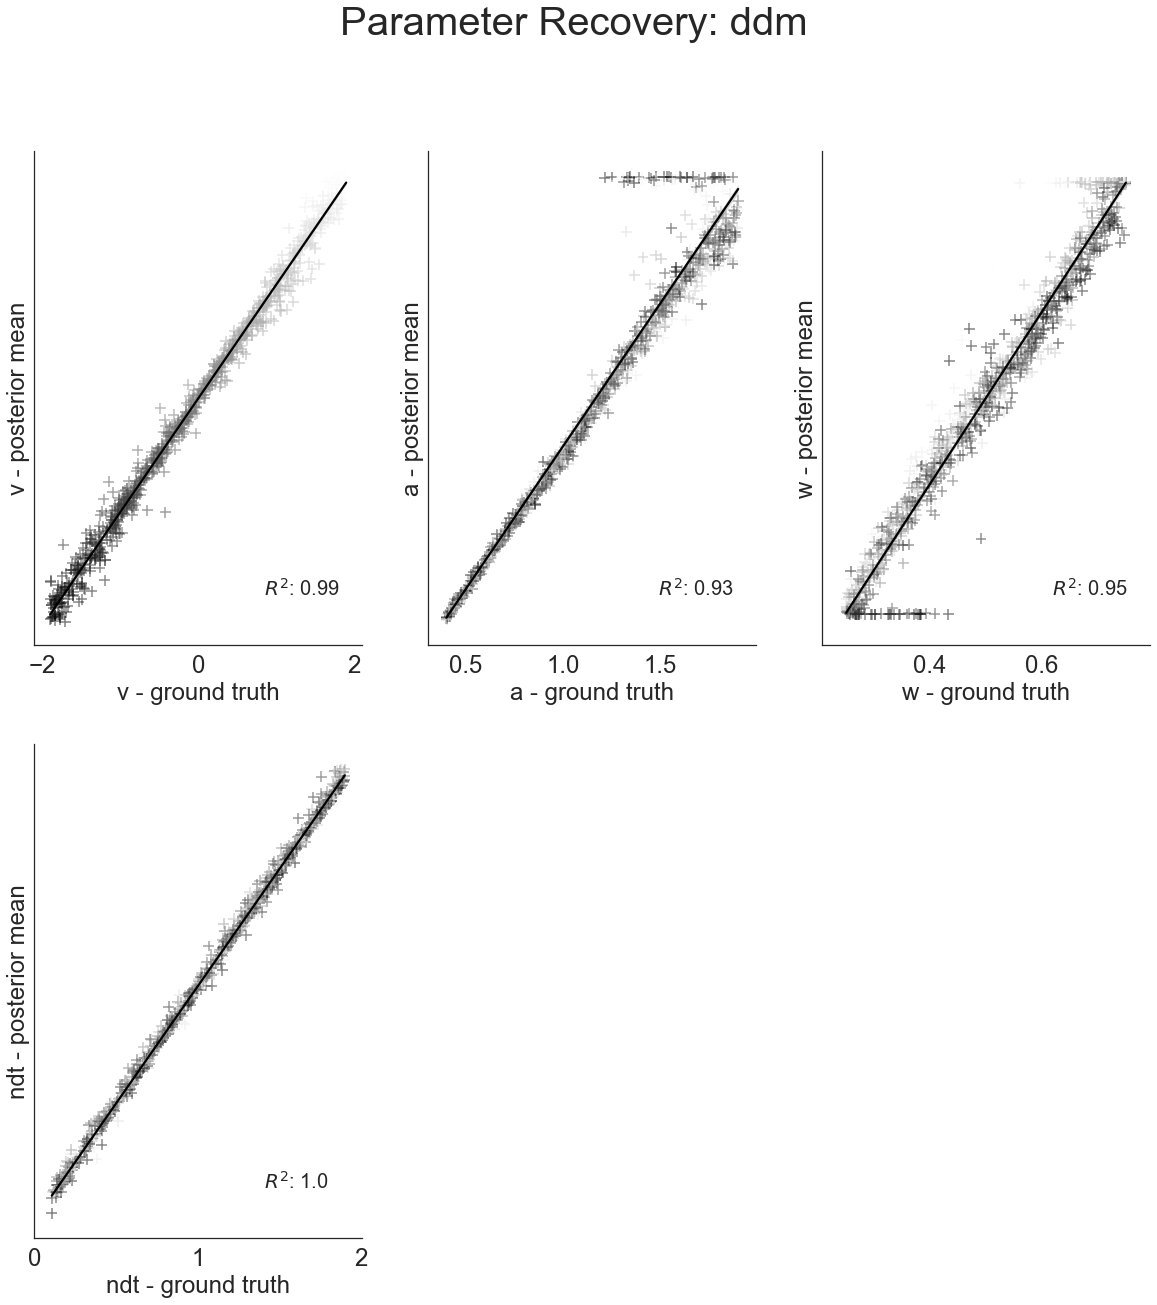

In [268]:
# PARAMETER RECOVERY PLOTS: KDE
parameter_recovery_plot(ax_titles = ax_titles_ddm,
                        title = 'Parameter Recovery: ' + model,
                        ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :],
                        estimates = mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :],
                        r2_vec = r2_vec_means,
                        cols = 3,
                        save = True)

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


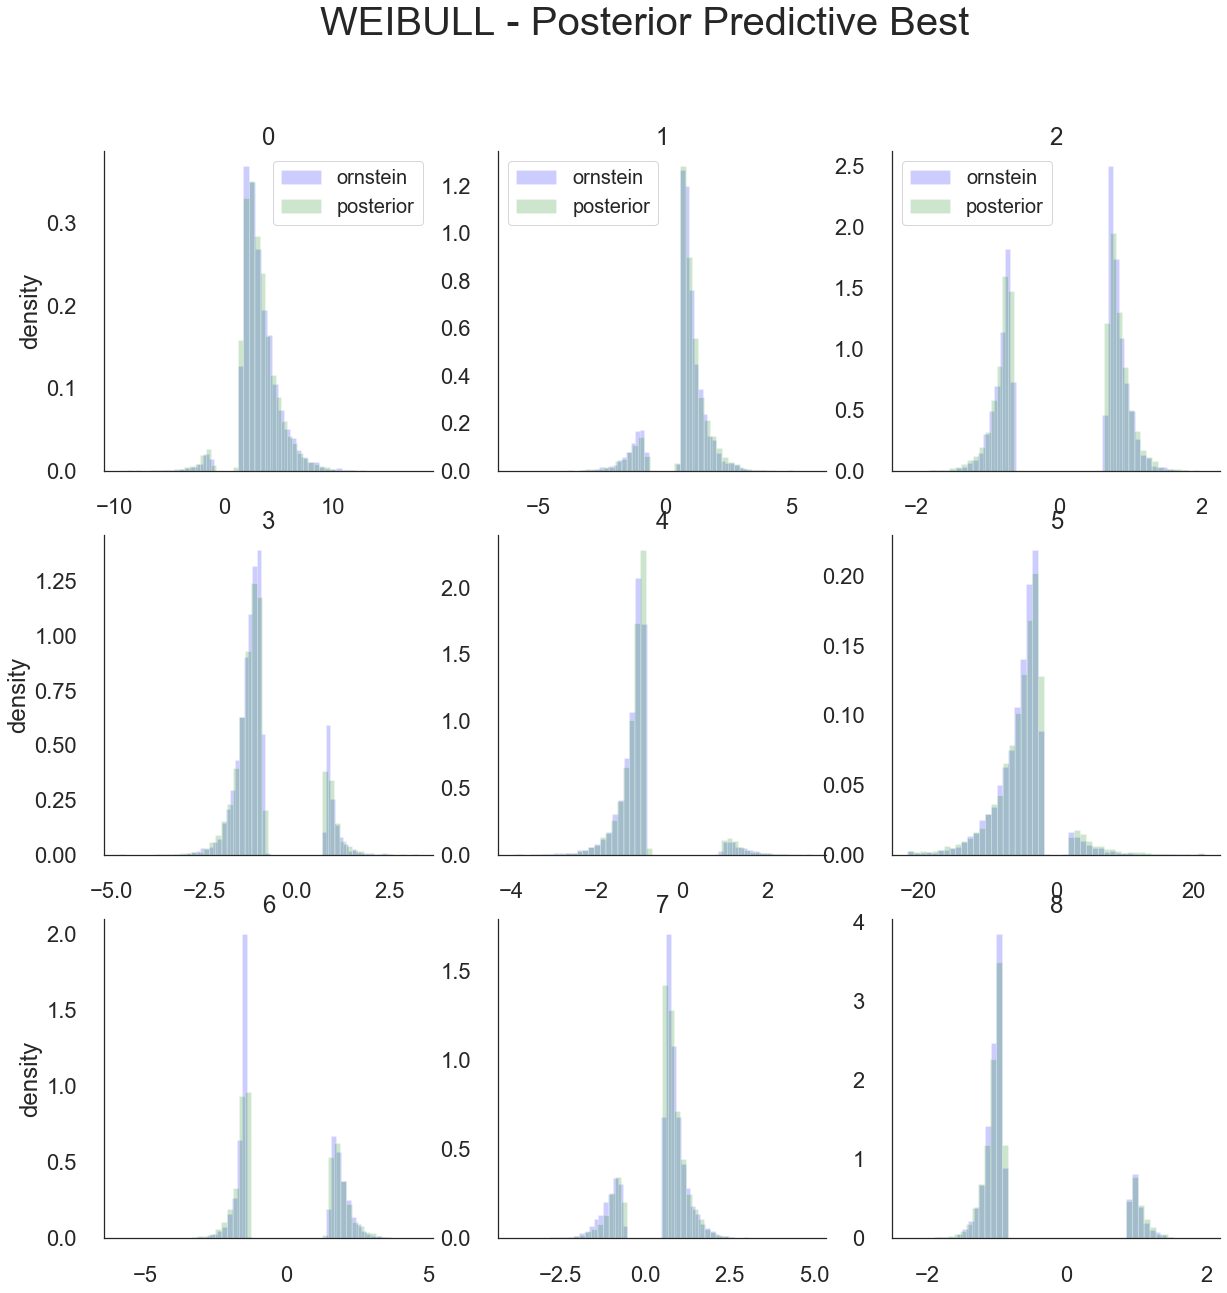

In [161]:
# Best
posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                              title = 'WEIBULL - Posterior Predictive Best',
                              posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][:10, :, :], # dat_total[1][bottom_idx, 5000:, :],
                              ground_truths =  mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :][:10, :], #dat_total[0][bottom_idx, :],
                              cols = 3,
                              model = 'ornstein',
                              figure_name = 'bg_posterior_predictive',
                              n_post_params = 500,
                              samples_by_param = 10,
                              show = True)

In [49]:
 mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :][:10, :][1,:]

array([0.48137525, 1.15448415, 0.33034685, 1.8591224 , 1.3127147 ,
       1.80091929])

In [294]:
# A of T plot
def compute_boundary_rmse(mode = 'max_t_global', # max_t_global, max_t_local, quantile
                          boundary_fun = bf.weibull_cdf, # bf.angle etc.
                          parameters_estimated =  mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :],
                          parameters_true = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :],
                          model = 'weibull_cdf',
                          max_t = 20,
                          n_probes = 1000):
    

    parameters_estimated_tup = tuple(map(tuple, parameters_estimated[:, 4:]))
    
    #print(parameters_estimated_tup)
    parameters_true_tup = tuple(map(tuple, parameters_true[:, 4:]))
    t_probes = np.linspace(0, max_t, n_probes)
    bnd_est = np.zeros((len(parameters_estimated), n_probes))
    bnd_true = np.zeros((len(parameters_estimated), n_probes))
    
    # get bound estimates
    for i in range(len(parameters_estimated)):
        #print(parameters_estimated[i])
        if model == 'weibull_cdf':
            bnd_est[i] = np.maximum(parameters_estimated[i, 1] * boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]), 0)
            bnd_true[i] = np.maximum(parameters_true[i, 1] * boundary_fun(*(t_probes, ) + parameters_true_tup[i]), 0)
        if model == 'angle':
            bnd_est[i] = np.maximum(parameters_estimated[i, 1] + boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]), 0)
            bnd_true[i] = np.maximum(parameters_true[i, 1] + boundary_fun(*(t_probes, ) + parameters_true_tup[i]), 0)
            #print(parameters_estimated[i, 1] * boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]))
            #print(bnd_true[i])
        else:
            bnd_est[i] = parameters_estimated[i, 1]
            bnd_true[i] = parameters_estimated[i, 1]
            
        #print(boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]))
        #bnd_est[i] = np.maximum(boundary_fun(parameters_estimated[i], t = t_probes), 0)
        #bnd_true[i] = np.maximum(boundary_fun(parameters_true[i], t = t_probes), 0)
        if i % 100 == 0:
            print(i)
    # compute rmse
    rmse_vec = np.zeros((len(parameters_estimated_tup)))
    dist_param_euclid = np.zeros((len(parameters_estimated_tup)))
    for i in range(len(parameters_estimated)):
        rmse_vec[i] = np.sqrt(np.sum(np.square(bnd_est[i] - bnd_true[i])) / n_probes)
        dist_param_euclid[i] = np.sqrt(np.sum(np.square(parameters_estimated[i] - parameters_true[i])))
    
    return rmse_vec, dist_param_euclid

In [295]:
rmse, dist_param_euclid = compute_boundary_rmse(mode = 'max_t_global',
                                                boundary_fun = bf.angle, # bf.weibull_cdf,
                                                parameters_estimated = mcmc_dict['means'][mcmc_dict['r_hats'] < 1.01, :],
                                                parameters_true = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :],
                                                model = 'angle',
                                                max_t = 20,
                                                n_probes = 1000)

0
100
200
300
400
500


In [296]:
rmse

array([1.42052546e-02, 1.87080231e-01, 4.08890021e-02, 7.97987488e-03,
       1.56094896e-02, 1.41923640e-01, 5.07298419e-02, 1.24034463e-01,
       6.36851919e-03, 2.28308850e-02, 1.59248808e-02, 1.03252453e-03,
       6.93456707e-03, 4.24459233e-02, 9.03300157e-03, 7.87719847e-02,
       4.65425182e-03, 4.48736730e-02, 1.94284746e-02, 9.01756916e-03,
       2.04689091e-02, 5.17694864e-03, 1.80490751e-02, 2.40230929e-02,
       4.81207719e-02, 1.43135041e-02, 5.83852003e-02, 4.68463375e-03,
       4.23821723e-02, 3.94847498e-03, 1.44824198e-02, 7.48379528e-01,
       1.38707065e-02, 3.29805324e-01, 9.87277262e-02, 9.74464891e-03,
       1.19645204e-02, 1.33376572e-02, 1.08950160e-02, 3.15447070e-01,
       7.71528492e-03, 1.29163295e-02, 1.32912443e-02, 2.43586076e-02,
       7.34688922e-01, 5.44472991e-01, 2.57062080e-02, 4.33305394e-02,
       1.36970839e+00, 2.22589137e-01, 1.47909253e-02, 1.94205438e-02,
       3.31580905e-01, 6.21952401e-01, 4.23180812e-02, 8.90727174e-02,
      

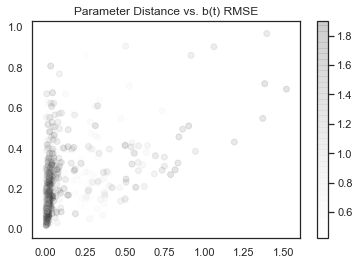

In [297]:
plt.scatter(rmse, dist_param_euclid, 
            c = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, 1],
            cmap = 'Greys', 
            alpha = 0.1)
plt.title('Parameter Distance vs. b(t) RMSE')
plt.colorbar()
plt.show()

In [298]:
sorted_idx = np.argsort(rmse)
bottom_idx = sorted_idx[:10]
middle_idx = sorted_idx[int(sorted_idx.shape[0] / 2) - 5: int(sorted_idx.shape[0] / 2) + 5]
top_idx = sorted_idx[-10:]

maxid 27
passed through
maxid 54
passed through
maxid 83
passed through
maxid 46
passed through
maxid 57
passed through
maxid 65
passed through
maxid 88
passed through
maxid 95
passed through
maxid 60
passed through


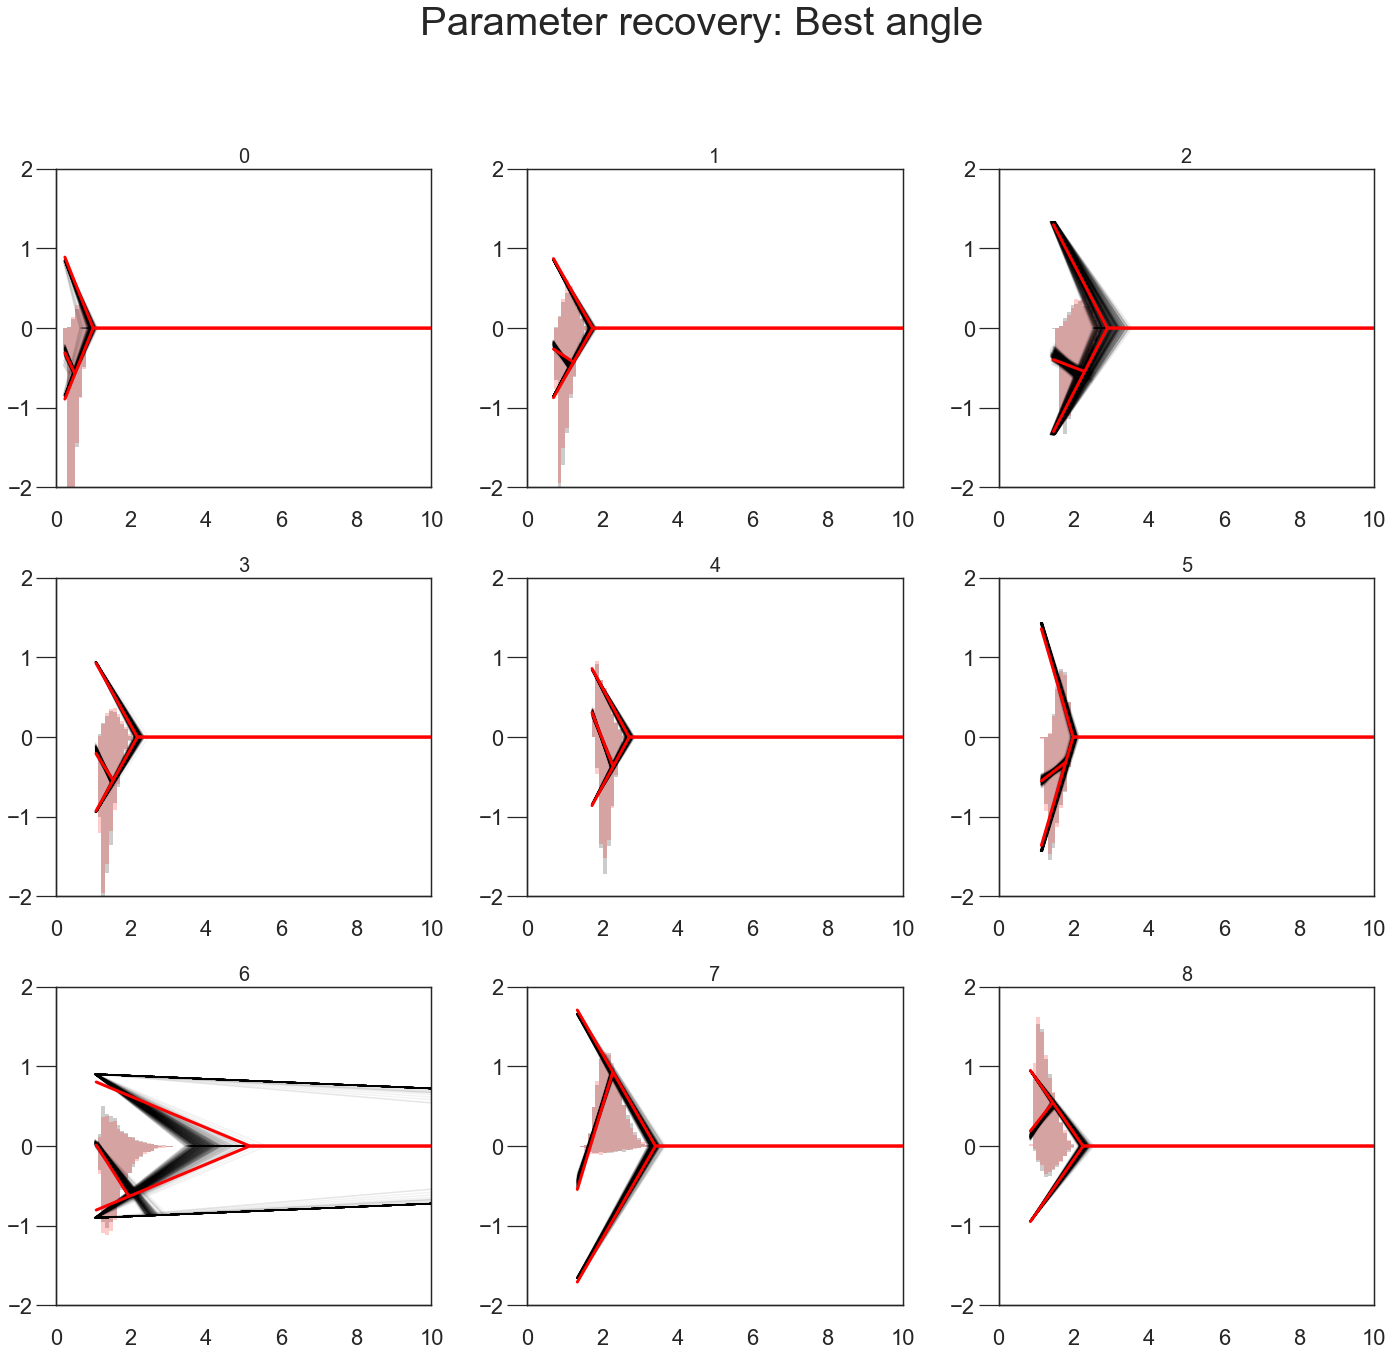

In [299]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter recovery: Best ',
                        posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][bottom_idx, :, :], # dat_total[1][bottom_idx, 5000:, :],
                        ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :][bottom_idx, :], #dat_total[0][bottom_idx, :],
                        cols = 3,
                        model = 'angle', # 'weibull_cdf',
                        figure_name = 'model_uncertainty_plot_bottom_',
                        n_post_params = 500,
                        samples_by_param = 10,
                        max_t = 10,
                        show = True,
                        save = True)

maxid 53
passed through
maxid 93
passed through
maxid 78
passed through
maxid 64
passed through
maxid 176
passed through
maxid 102
passed through
maxid 30
passed through
maxid 180
passed through
maxid 55
passed through


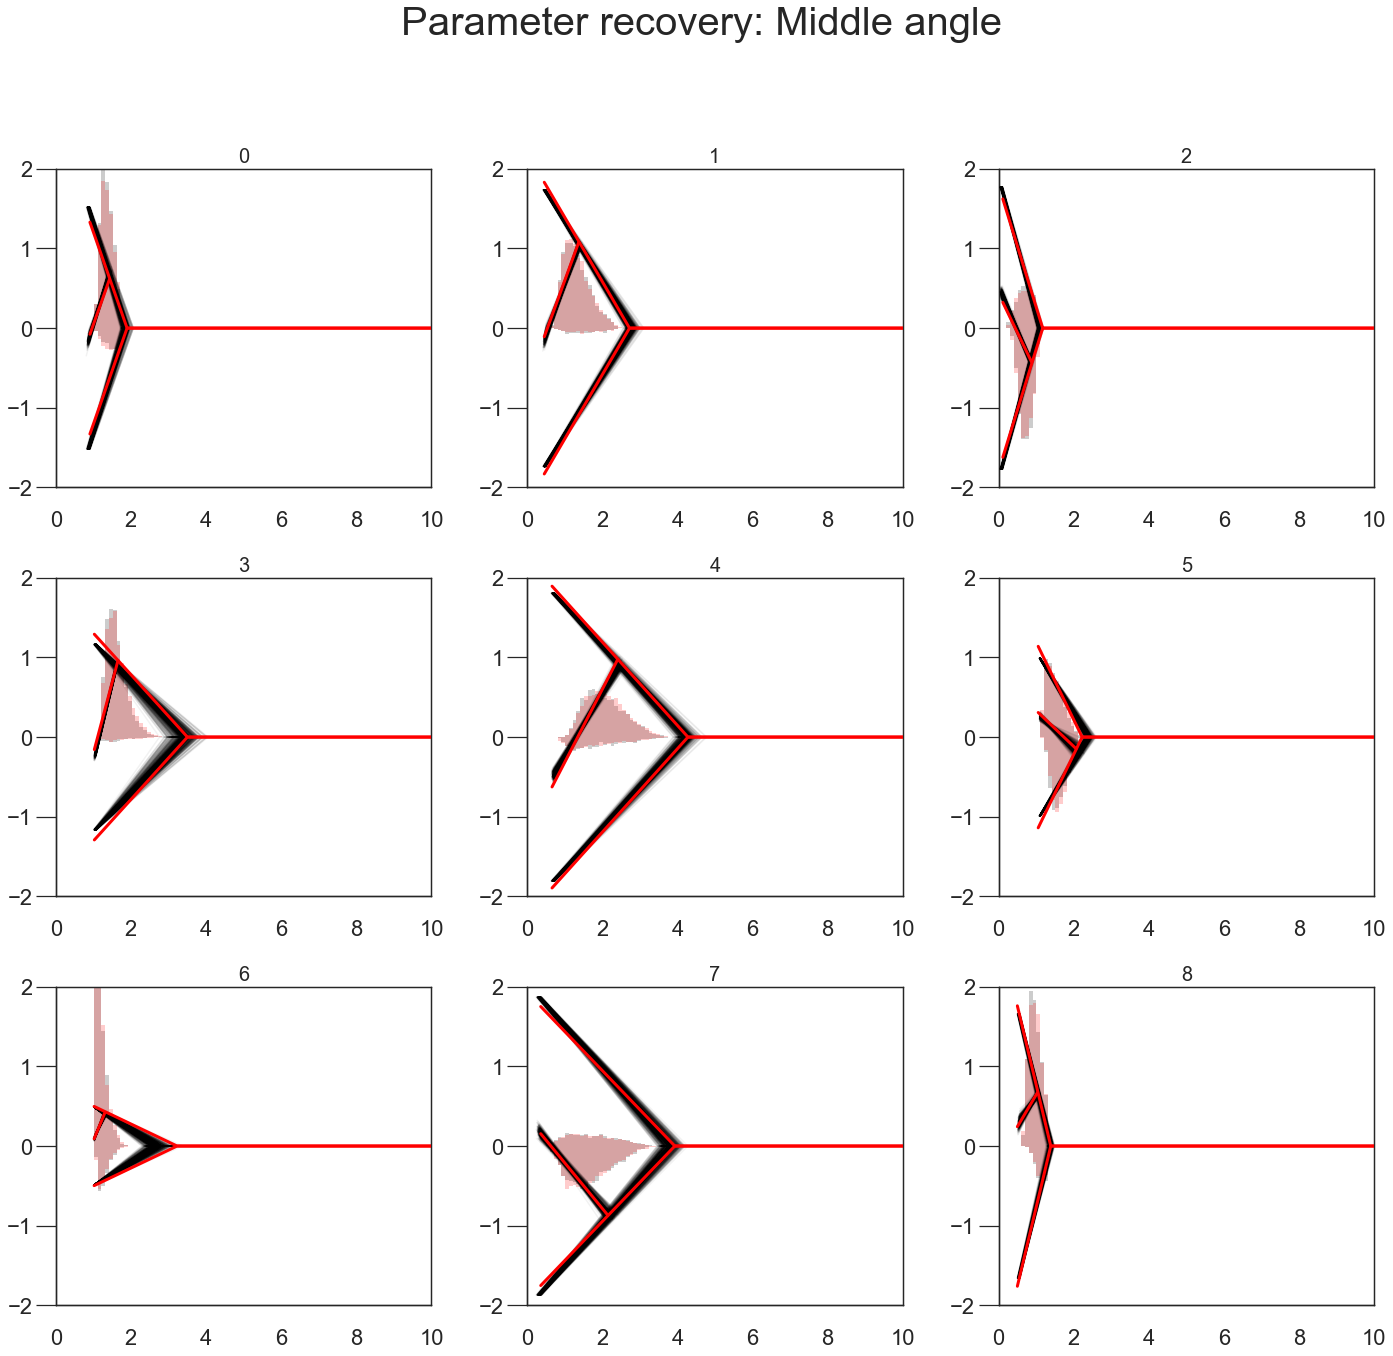

In [300]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter recovery: Middle ',
                        posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][middle_idx, :, :], # dat_total[1][bottom_idx, 5000:, :],
                        ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :][middle_idx, :], #dat_total[0][bottom_idx, :],
                        cols = 3,
                        model = 'angle', #'weibull_cdf',
                        figure_name = 'model_uncertainty_plot_middle_',
                        n_post_params = 500,
                        samples_by_param = 10,
                        max_t = 10,
                        show = True,
                        save = True)

maxid 553
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 41
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 55
passed through
maxid 43
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 43
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 73
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 64
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 66
passed through


/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


maxid 52
passed through


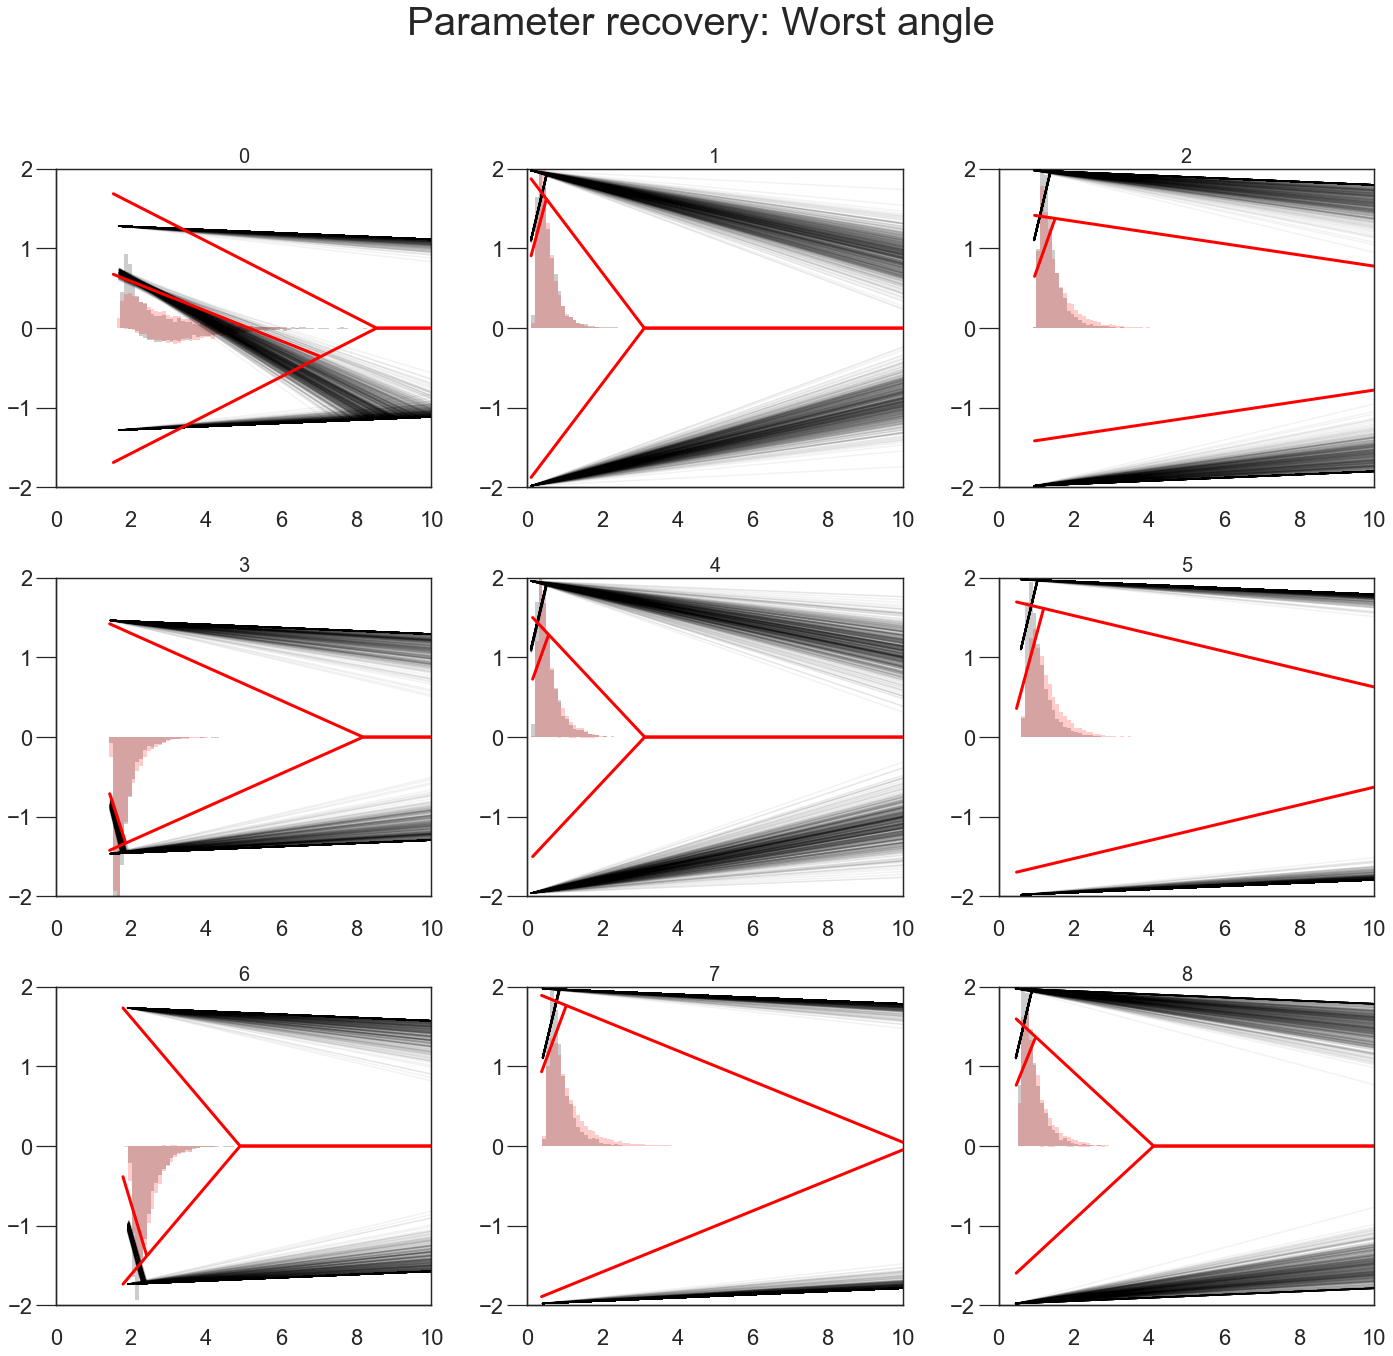

In [301]:
boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                        title = 'Parameter recovery: Worst ',
                        posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < 1.01, :, :][top_idx, :, :], # dat_total[1][bottom_idx, 5000:, :],
                        ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < 1.01, :][top_idx, :], #dat_total[0][bottom_idx, :],
                        cols = 3,
                        model = 'angle', #'weibull_cdf',
                        figure_name = 'model_uncertainty_plot_top_',
                        n_post_params = 500,
                        samples_by_param = 10,
                        max_t = 10,
                        show = True,
                        save = True)